# Binormal Flow Simulator (Euler)
Simulates binormal flow for different discretized curves:
- Hasimoto soliton
- Kelvin ring
- Normal ring

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## Curve Initializers

In [2]:
class CurveInitializer(ABC):
    """Base class for curve initialization."""
    
    @abstractmethod
    def initialize(self):
        """Return initial curve as (N, 3) numpy array."""
        pass
    
    @property
    @abstractmethod
    def name(self):
        """Return name of curve."""
        pass

In [3]:
class HasimotoSoliton(CurveInitializer):
    """Hasimoto soliton curve."""
    
    def __init__(self, s_min=-200, s_max=200, num_points=1500, nu=1.0, tau_0=0.5, t=0):
        self.s_min = s_min
        self.s_max = s_max
        self.num_points = num_points
        self.nu = nu
        self.tau_0 = tau_0
        self.t = t
    
    def initialize(self):
        s = np.linspace(self.s_min, self.s_max, self.num_points)
        
        eta = self.nu * (s - 2 * self.tau_0 * self.t)
        mu = 1 / (1 + self.tau_0**2)
        gamma_amp = (2 * mu * (1 / np.cosh(eta))) / self.nu
        theta = self.tau_0 * s + (self.nu**2 - self.tau_0**2) * self.t
        
        x = s - (2 * mu / self.nu) * np.tanh(eta)
        y = gamma_amp * np.cos(theta)
        z = gamma_amp * np.sin(theta)
        
        return np.stack((x, y, z), axis=1)
    
    @property
    def name(self):
        return "Hasimoto Soliton"

In [4]:
class KelvinRing(CurveInitializer):
    """Kelvin ring curve."""
    
    def __init__(self, R=1.0, A=0.5, N=10, num_points=500):
        self.R = R
        self.A = A
        self.N = N
        self.num_points = num_points
    
    def initialize(self):
        phi = np.linspace(0, 2 * np.pi, self.num_points)
        
        x = self.R * np.cos(phi) + self.A * np.cos(self.N * phi) * np.cos(phi)
        y = self.R * np.sin(phi) + self.A * np.cos(self.N * phi) * np.sin(phi)
        z = -self.A * np.sin(self.N * phi)
        
        return np.stack((x, y, z), axis=1)
    
    @property
    def name(self):
        return "Kelvin Ring"

In [5]:
class NormalRing(CurveInitializer):
    """Simple circular ring."""
    
    def __init__(self, R=1.0, num_points=100):
        self.R = R
        self.num_points = num_points
    
    def initialize(self):
        theta = np.linspace(0, 2 * np.pi, self.num_points)
        x = self.R * np.cos(theta)
        y = self.R * np.sin(theta)
        z = np.zeros_like(theta)
        
        return np.stack((x, y, z), axis=1)
    
    @property
    def name(self):
        return "Normal Ring"

## Core Binormal Flow Computation

In [6]:
def compute_binormal_flow_step(curve):
    """
    Compute binormal flow quantities for a curve.
    
    Returns:
        tangent_unit: unit tangent vectors
        normal: unit normal vectors
        binormal: unit binormal vectors (T × N)
        curvature_mag: magnitude of curvature
    """
    # tangent from finite differences
    tangent = np.gradient(curve, axis=0, edge_order=2)
    tangent_norm = np.linalg.norm(tangent, axis=1, keepdims=True)
    tangent_unit = tangent / tangent_norm
    
    # curvature from second derivative
    tangent2 = np.gradient(tangent_unit, axis=0, edge_order=2)
    curvature_vec = tangent2
    curvature_mag = np.linalg.norm(curvature_vec, axis=1, keepdims=True)
    
    # normal direction
    normal = curvature_vec / (curvature_mag + 1e-8)
    
    # binormal = tangent × normal
    binormal = np.cross(tangent_unit, normal)
    
    return tangent_unit, normal, binormal, curvature_mag

## Simulation and Plotting

In [7]:
def simulate_binormal_flow(initializer, dt=0.01, n_steps=201, 
                          track_length=False, viz_interval=None):
    """
    Simulate binormal flow for a curve.
    
    Args:
        initializer: CurveInitializer instance
        dt: time step
        n_steps: number of steps
        track_length: whether to print curve length at intervals
        viz_interval: visualization interval (default: n_steps // 4)
    
    Returns:
        curve_history: list of curves at each visualization step
        steps: list of step numbers at visualization steps
    """
    if viz_interval is None:
        viz_interval = max(1, n_steps // 4)
    
    curve = initializer.initialize()
    curve_history = []
    steps = []
    
    for step in range(n_steps):
        # compute flow
        _, _, binormal, curvature_mag = compute_binormal_flow_step(curve)
        
        # time step
        curve += dt * curvature_mag * binormal
        
        # track and visualize
        if step % viz_interval == 0 or step == n_steps - 1:
            curve_history.append(curve.copy())
            steps.append(step)
            
            if track_length:
                segment_lengths = np.linalg.norm(np.roll(curve, -1, axis=0) - curve, axis=1)
                total_length = np.sum(segment_lengths)
                print(f"{initializer.name} - step {step}: length = {total_length:.6f}")
    
    return curve_history, steps

In [8]:
def plot_simulation(initializer, curve_history, steps, dt):
    """Plot 3D visualization of curve evolution."""
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    for curve, step in zip(curve_history, steps):
        ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], 
               label=f"t = {step * dt:.2f}")
    
    ax.set_title(f'Time Evolution - {initializer.name}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    plt.tight_layout()
    
    return fig, ax

In [9]:
def run_simulation(initializer, dt=0.01, n_steps=201, 
                  track_length=False, viz_interval=None):
    """Convenience function to run and plot a simulation."""
    print(f"\nRunning {initializer.name}...")
    curve_history, steps = simulate_binormal_flow(
        initializer, dt, n_steps, track_length, viz_interval
    )
    fig, ax = plot_simulation(initializer, curve_history, steps, dt)
    plt.show()
    
    return curve_history, steps, fig, ax

## Run Simulations

### Hasimoto Soliton


Running Hasimoto Soliton...


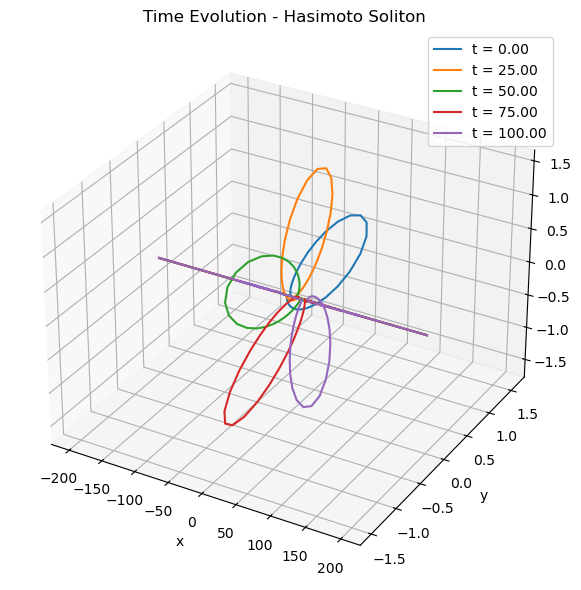

In [10]:
soliton = HasimotoSoliton()
soliton_curves, soliton_steps, soliton_fig, soliton_ax = run_simulation(
    soliton, dt=0.01, n_steps=10001, track_length=False
)

### Kelvin Ring


Running Kelvin Ring...
Kelvin Ring - step 0: length = 32.091126
Kelvin Ring - step 50: length = 32.092029
Kelvin Ring - step 100: length = 32.094978
Kelvin Ring - step 150: length = 32.100916
Kelvin Ring - step 200: length = 32.110612


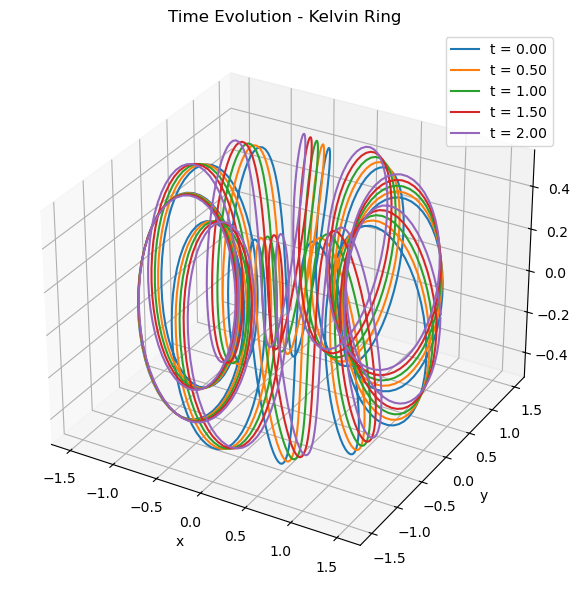

In [11]:
kelvin = KelvinRing()
kelvin_curves, kelvin_steps, kelvin_fig, kelvin_ax = run_simulation(
    kelvin, dt=0.01, n_steps=201, track_length=True
)

### Normal Ring


Running Normal Ring...


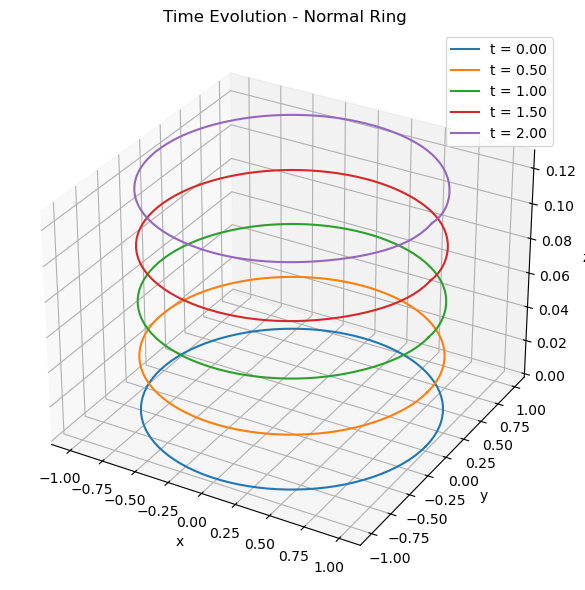

In [12]:
ring = NormalRing()
ring_curves, ring_steps, ring_fig, ring_ax = run_simulation(
    ring, dt=0.01, n_steps=201, track_length=False
)